In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [31]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy
0,11,1,5,124,636,324,448,48,34,58,...,False,False,False,False,False,False,False,False,False,False
1,11,1,5,371,2475,340,531,48,34,58,...,False,False,False,False,False,False,False,False,False,False
2,11,1,5,181,1069,301,482,48,34,58,...,False,False,False,False,False,False,False,False,False,False
3,11,1,5,168,944,345,513,48,34,58,...,False,False,False,False,False,False,False,False,False,False
4,11,1,5,139,760,360,499,46,32,58,...,False,False,False,False,False,False,False,False,False,False


In [32]:
X = df.drop(columns=["DEP_DELAY"])
y = df["DEP_DELAY"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training accuracy: 0.9378036086051353
Testing accuracy: 0.8957321304649549
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4950
           1       0.80      0.35      0.49       814

    accuracy                           0.90      5764
   macro avg       0.85      0.67      0.71      5764
weighted avg       0.89      0.90      0.88      5764



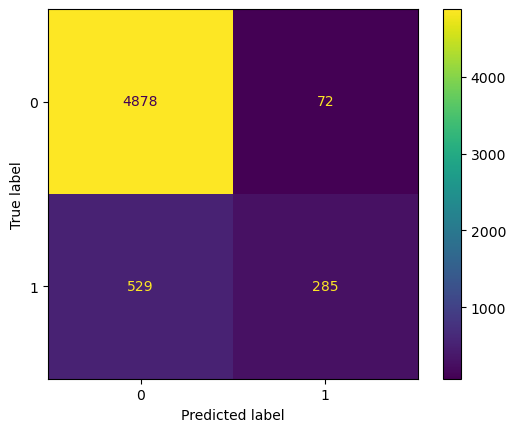

In [61]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

### Hyperparamter Tuning

Using scale_pos_weight: 6.189273464296851
Training accuracy: 0.9191099930603748
Testing accuracy: 0.8346634281748786
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      4950
           1       0.44      0.58      0.50       814

    accuracy                           0.83      5764
   macro avg       0.68      0.73      0.70      5764
weighted avg       0.86      0.83      0.84      5764



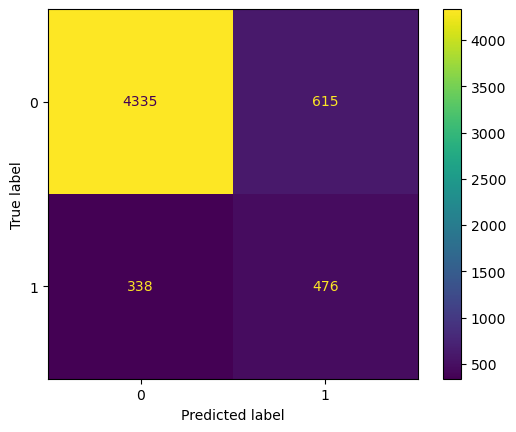

In [ ]:
# Calculate scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Using scale_pos_weight: {scale_pos_weight}")

# Define XGBoost model with only scale_pos_weight changed
model = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    scale_pos_weight=scale_pos_weight  # Adjusted for class imbalance
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Print accuracy
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()


In [74]:
# Define the parameter grid (with distributions for RandomizedSearch)
param_dist = {
    'scale_pos_weight': [5, 6, 7],
    'max_depth': [6, 7, 8],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400],
    'gamma': [0, 0.5, 1],
    'subsample': [0.7, 0.8, 0.9]
}

# Setup RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of random samples to try
    scoring='f1_macro',  # Optimize for F1-score
    cv=3,  # Number of folds for cross-validation
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Print the best parameters found
print(f"Best parameters: {random_search.best_params_}")

# Get the best model
best_random_model = random_search.best_estimator_

# Make predictions
y_pred_random = best_random_model.predict(X_test)

# Evaluate performance
print(f"Training accuracy: {best_random_model.score(X_train, y_train)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred_random)}")
print(classification_report(y_test, y_pred_random))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'subsample': 0.7, 'scale_pos_weight': 5, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1}
Training accuracy: 0.9733258154059681
Testing accuracy: 0.8672796668979875
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4950
           1       0.53      0.54      0.53       814

    accuracy                           0.87      5764
   macro avg       0.73      0.73      0.73      5764
weighted avg       0.87      0.87      0.87      5764

